Xarray-spatial provides a utility function to easily resample geospatial image data, which wraps some mapshader's functions like [Canvas](https://datashader.org/api.html#datashader.Canvas) and [shade](https://datashader.org/api.html#datashader.transfer_functions.shade).

The following notebook will demonstrate how to use the resample function doing some common operations like Interpolation (upsampling) and Aggregation (downsampling).

Some of the examples used in this notebook were adapted from https://datashader.org/user_guide/Grids.html.

## Importing Packages

In [1]:
import dask.array as da
import datashader as ds
from datashader import colors
from datashader import transfer_functions as tf
import noise
import numpy as np
import pandas as pd
import xarray as xr

## Making sample data

Make a sample terrain data using the **make_terrain** function, which will be available on the Xarray-spatial release v0.2.3 in the datasets module.

In [2]:
def make_terrain(
    shape=(1024, 1024),
    scale=100.0,
    octaves=6,
    persistence=0.5,
    lacunarity=2.0,
    chunks=(512, 512)
):
    """
    Generate a pseudo-random terrain data dask array.

    Parameters
    ----------
    shape : int or tuple of int, default=(1024, 1024)
        Output array shape.
    scale : float, default=100.0
        Noise factor scale.
    octaves : int, default=6
        Number of waves when generating the noise.
    persistence : float, default=0.5
        Amplitude of each successive octave relative.
    lacunarity : float, default=2.0
        Frequency of each successive octave relative.
    chunks : int or tuple of int, default=(512, 512)
        Number of samples on each block.

    Returns
    -------
    terrain : xarray.DataArray
        2D array of generated terrain values.
    """
    def _func(arr, block_id=None):
        block_ystart = block_id[0] * arr.shape[0]
        block_xstart = block_id[1] * arr.shape[1]
        out = np.zeros(arr.shape)
        for i in range(out.shape[0]):
            for j in range(out.shape[1]):
                out[i][j] = noise.pnoise2(
                    (block_ystart + i)/scale,
                    (block_xstart + j)/scale,
                    octaves=octaves,
                    persistence=persistence,
                    lacunarity=lacunarity,
                    repeatx=1024,
                    repeaty=1024,
                    base=42,
                )
        return out

    data = (
        da.zeros(shape=shape, chunks=chunks, dtype=np.float32)
        .map_blocks(_func, dtype=np.float32)
    )

    cvs = ds.Canvas(
        x_range=(0, 500),
        y_range=(0, 500),
        plot_width=shape[1],
        plot_height=shape[0],
    )

    hack_agg = cvs.points(pd.DataFrame({'x': [], 'y': []}), 'x', 'y')

    agg = xr.DataArray(
        data,
        name='terrain',
        coords=hack_agg.coords,
        dims=hack_agg.dims,
        attrs={'res': 1},
    )

    return agg

In [3]:
terrain = make_terrain(shape=(300, 300), chunks=(50, 50), persistence=0.5, scale=50, lacunarity=6.0)
terrain

<xarray.DataArray 'terrain' (y: 300, x: 300)>
dask.array<_func, shape=(300, 300), dtype=float32, chunksize=(50, 50), chunktype=numpy.ndarray>
Coordinates:
  * x        (x) float64 0.8333 2.5 4.167 5.833 7.5 ... 494.2 495.8 497.5 499.2
  * y        (y) float64 0.8333 2.5 4.167 5.833 7.5 ... 494.2 495.8 497.5 499.2
Attributes:
    res:      1

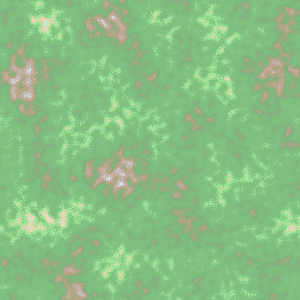

In [4]:
tf.shade(terrain, cmap=colors.Elevation, alpha=128, how='linear')

## Resample function

Currently, the resample function is not available. However, it'll be demonstrated in the following notebook and available on the Xarray-spatial release v0.2.3.

In [5]:
def resample_shade(
        raster,
        name=None,
        layer=None,
        height=512,
        width=512,
        x_range=None,
        y_range=None,
        agg='mean',
        interpolate='linear',
        cmap=colors.Elevation,
        alpha=128,
        how='linear',
        max_mem=None,
    ):
    """
    Resample a xarray.DataArray by canvas size and bounds.
    
    Handles 2D or 3D xarray.DataArray, assuming that the last two
    array dimensions are the y-axis and x-axis that are to be
    resampled. If a 3D array is supplied a layer may be specified
    to resample to select the layer along the first dimension to
    resample.
    
    If there are memory constraints they may be defined using the
    max_mem parameter, which determines how large the chunks in
    memory may be.

    Parameters
    ----------
    raster : xarray.DataArray
        2D or 3D labeled data array.
    name : str, optional
        Optional string name to give to the Image object to return,
        to label results for display.
    layer : float, optional
        For a 3D array, value along the z dimension : 
    height : int, default=512
        Height of the output aggregate in pixels.
    width : int, default=512
        Width of the output aggregate in pixels.
    x_range : tuple of int, optional
        A tuple representing the bounds inclusive space ``[min, max]`` along
        the x-axis.
    y_range : tuple of int, optional
        A tuple representing the bounds inclusive space ``[min, max]`` along
        the y-axis.
    agg : Reduction, default=mean
        Resampling mode when downsampling raster. The supported
        options include: first, last, mean, mode, var, std, min,
        The agg can be specified as either a string name or as a
        reduction function, but note that the function object will
        be used only to extract the agg type (mean, max, etc.) and
        the optional column name; the hardcoded raster code
        supports only a fixed set of reductions and ignores the
        actual code of the provided agg.
    interpolate : str, default=linear
        Method to use for interpolation between specified values. ``nearest``
        means to use a single value for the whole triangle, and ``linear``
        means to do bilinear interpolation of the pixels within each
        triangle (a weighted average of the vertex values).
    cmap : list of colors or matplotlib.colors.Colormap, 
        default=datashader.colors.Elevation
        The colormap to use for 2D agg arrays. Can be either a list of
        colors (specified either by name, RGBA hexcode, or as a tuple
        of ``(red, green, blue)`` values), or a matplotlib colormap
        object.
    alpha : int, default=128
        Value between 0 - 255 representing the alpha value to use for
        colormapped pixels that contain data (i.e. non-NaN values).
        Also used as the maximum alpha value when alpha is indicating
        data value, such as for single colors or categorical plots.
        Regardless of this value, ``NaN`` values are set to be fully
        transparent when doing colormapping.
    how : str or callable, default=linear
        The interpolation method to use, for the ``cmap`` of a 2D
        DataArray or the alpha channel of a 3D DataArray. Valid
        strings are 'eq_hist', 'cbrt' (cube root), 'log'
        (logarithmic), and 'linear'. Callables take 2 arguments - a
        2-dimensional array of magnitudes at each pixel, and a boolean
        mask array indicating missingness. They should return a numeric
        array of the same shape, with ``NaN`` values where the mask was
        True.
    max_mem : int, optional
        The maximum number of bytes that should be loaded into memory
        during the regridding operation.
    
    References
    ----------
        - https://datashader.org/_modules/datashader/core.html#Canvas
        - https://datashader.org/_modules/datashader/transfer_functions.html#shade
    """
    cvs = ds.Canvas(
        plot_height=height,
        plot_width=width,
        x_range=x_range,
        y_range=y_range,
    )
    
    out = cvs.raster(raster, layer=layer, agg=agg, interpolate=interpolate, max_mem=max_mem)

    return tf.shade(out, cmap=cmap, alpha=alpha, how=how, name=name)

### Interpolation (upsampling)

linear interpolation,nearest-neighbor interpolation

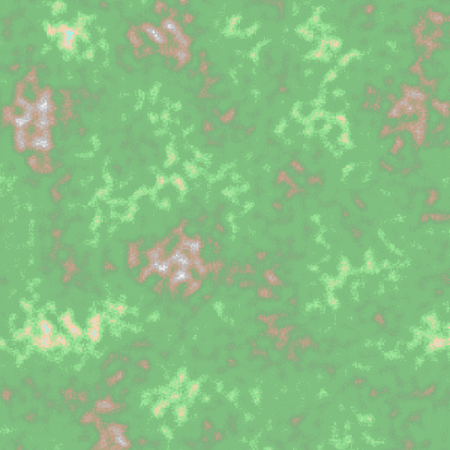
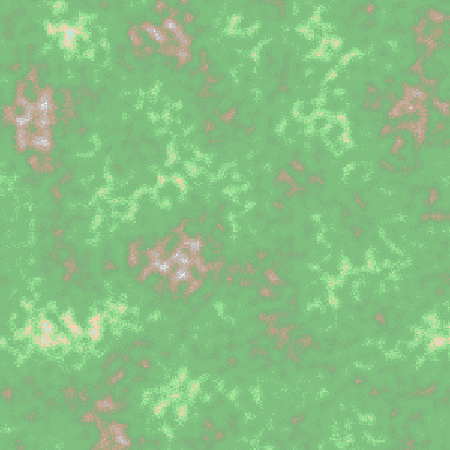

In [6]:
tf.Images(
    resample_shade(terrain, height=450, width=450, interpolate='linear', name='linear interpolation'),
    resample_shade(terrain, height=450, width=450, interpolate='nearest', name='nearest-neighbor interpolation'),
)

### Aggregation (downsampling)

mean downsampling,min downsampling,max downsampling,mode downsampling,std downsampling

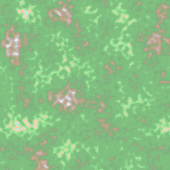
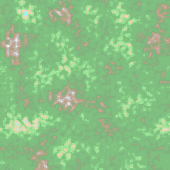
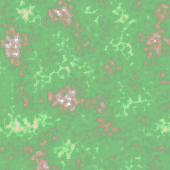
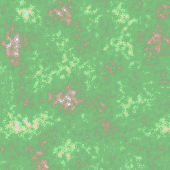
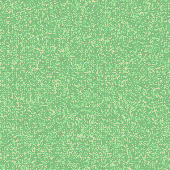

In [7]:
tf.Images(
    resample_shade(terrain, height=170, width=170, agg='mean', name='mean downsampling'),
    resample_shade(terrain, height=170, width=170, agg='min', name='min downsampling'),
    resample_shade(terrain, height=170, width=170, agg='max', name='max downsampling'),
    resample_shade(terrain, height=170, width=170, agg='mode', name='mode downsampling'),
    resample_shade(terrain, height=170, width=170, agg='std', name='std downsampling'),
 )